# Neural Network

Our third and last model evaluated in the task of Fetal Health Classification is a Neural Network. We use the TensorFlow library to develop this model.

### Importing Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from sklearn.model_selection import train_test_split, cross_validate, KFold
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import CategoricalAccuracy, F1Score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, f1_score,\
     roc_auc_score, balanced_accuracy_score, make_scorer, classification_report
import pyprojroot
import pickle

We set a random seed for reproducibility.

In [3]:
RANDOM_STATE = 11

## 1. Data Preprocessing

In [85]:
DATA_PATH = pyprojroot.here().joinpath('data', 'fetal_health.csv')
df = pd.read_csv(DATA_PATH)

In [86]:
df['fetal_health'] = df['fetal_health']-1

In [87]:
# Split data into train, test and validation sets
train, validate, test = np.split(df.sample(frac=1, random_state=RANDOM_STATE), [int(.7*len(df)), int(.8*len(df))])

/home/joselier/miniconda3/envs/capstone-project/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [88]:
X_train = train[df.columns.difference(['fetal_health', 'fetal_health_label'])]
y_train = train['fetal_health']

X_test = test[df.columns.difference(['fetal_health', 'fetal_health_label'])]
y_test = test['fetal_health']

X_val = validate[df.columns.difference(['fetal_health', 'fetal_health_label'])]
y_val = validate['fetal_health']

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

In [91]:
# One-hot encode our target variable
num_classes = len(df['fetal_health'].unique())
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

## 2. Model Training

In [139]:
model = Sequential()

# layer 1
model.add(Dense(128, 
    kernel_regularizer=regularizers.l2(1e-4),
    input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# layer 2
model.add(Dense(64, 
                kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
          
# layer 3
model.add(Dense(32, 
                kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
          
# Classification
model.add(Dense(3, 
                kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,147 (55.26 KB)

 Trainable params: 13,699 (53.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [140]:
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(),
             metrics=[
                CategoricalAccuracy(),
                F1Score()
             ])

In [141]:
MODEL_PATH = pyprojroot.here().joinpath('models', 'neural_net.keras')

# Defining our callbacks
early = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(MODEL_PATH, 
                             verbose=1,
                            save_best_only=True,
                            monitor='val_loss')

In [142]:
hist = model.fit(X_train_scaled, y_train,
                callbacks=[checkpoint],
                epochs=120,
                validation_data=(X_val_scaled, y_val))

Epoch 1/120


45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5030 - f1_score: 0.4039 - loss: 1.3301
Epoch 1: val_loss improved from inf to 0.70979, saving model to /home/joselier/capstone-fuse.ai/models/neural_net.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy: 0.5091 - f1_score: 0.4091 - loss: 1.3145 - val_categorical_accuracy: 0.8396 - val_f1_score: 0.7013 - val_loss: 0.7098
Epoch 2/120
43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.7676 - f1_score: 0.6306 - loss: 0.6825
Epoch 2: val_loss improved from 0.70979 to 0.44969, saving model to /home/joselier/capstone-fuse.ai/models/neural_net.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - categorical_accuracy: 0.7680 - f1_score: 0.6310 - loss: 0.6820 - val_categorical_accuracy: 0.8915 - val_f1_score: 0.7633 - val_loss: 0.4497
Epoch 3/120
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8394 - f1_score: 0.7161 - loss: 0.5453
Epoch 3: val_loss improved from 0.44969 to 0.36868, sav

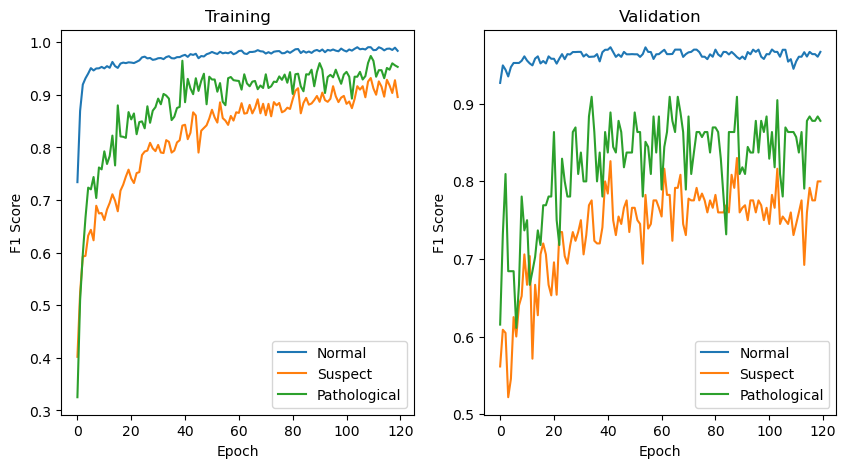

In [151]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

train_val = hist.history['val_f1_score']
ax[0].plot(range(len(train_val)), hist.history['f1_score'])
ax[0].set_ylabel('F1 Score')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training')
ax[0].legend(['Normal', 'Suspect', 'Pathological'], loc='best')

ax[1].plot(range(len(train_val)), hist.history['val_f1_score'])
ax[1].set_ylabel('F1 Score')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation')
ax[1].legend(['Normal', 'Suspect', 'Pathological'], loc='best')

plt.show()

## 3. Evaluation

We're using cross validation to precisely evaluate model performance, independent from random data partitions, which may influence our metrics.

In [152]:
best_nn = load_model(MODEL_PATH)

In [154]:
metrics = {
    'accuracy': accuracy_score,
    'balanced_accuracy': balanced_accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0),
    'f1_score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro', zero_division=0),
}

for key in metrics.keys():
    metrics[key] = make_scorer(metrics[key])

In [155]:
cv_result = cross_validate(best_nn, X_test_scaled, y_test, scoring=metrics,\
    cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE), return_estimator=True)
cv_result_df = pd.DataFrame(cv_result)

TypeError: Cannot clone object '<Sequential name=sequential_5, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [54]:
cv_result_df = cv_result_df.drop('estimator', axis=1)
cv_result_df.mean()

fit_time                  0.335880
score_time                0.018012
test_accuracy             0.882669
test_balanced_accuracy    0.718183
test_precision            0.844558
test_f1_score             0.751041
dtype: float64

We can see that dummy classifier has very low performance. These will be our baseline metrics.

In [63]:
y_pred = grid_search.predict(X_test)

In [64]:
labels = [1, 2, 3]
target_names = ['Normal', 'Suspect', 'Pathological']

In [65]:
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       332
     Suspect       0.72      0.73      0.72        59
Pathological       0.94      0.86      0.90        35

    accuracy                           0.91       426
   macro avg       0.87      0.85      0.86       426
weighted avg       0.91      0.91      0.91       426



Here, we can see in more detail our metrics calculated per class.

## 4. Saving the Model

We're using the _pickle_ library for saving our models.

In [66]:
MODEL_PATH = pyprojroot.here().joinpath('models', 'forest_clf.pkl')

# Save the model
with open(MODEL_PATH,'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)